**Master IASD 2025**

Deep Learning for Image Analisis

**Generative Model by Denoising Score Networks**

Practical Session: Nov 7-2025

You should submit the notebook with the answers be email before the deadline.

Deadline: Nov 14-2025

Santiago VELASCO-FORERO santiago.velasco@minesparis.psl.eu

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import math
import numpy as np

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print('Code is running in a '+ device)

#Learning rate for the experiments
lr=1e-3

# 2D Mixture of Gaussians
pi1, pi2 = 0.5, 0.5
mu1 = torch.tensor([-2.0, 1.0])
mu2 = torch.tensor([2.0, 1.0])
cov1 = torch.tensor([[3, 0.0], [0.0, .1]])
cov2 = torch.tensor([[.1, 0.0], [0.0, 3]])

inv_cov1 = torch.inverse(cov1)
inv_cov2 = torch.inverse(cov2)
det_cov1 = torch.det(cov1)
det_cov2 = torch.det(cov2)

def gaussian_pdf(x, mu, cov, inv_cov, det_cov):
    diff = x - mu
    exponent = -0.5 * torch.sum(diff @ inv_cov * diff, dim=1)
    norm = 1.0 / (2 * torch.pi * torch.sqrt(det_cov))
    return norm * torch.exp(exponent)

def true_score(x):
    # p1(x), p2(x)
    p1 = gaussian_pdf(x, mu1, cov1, inv_cov1, det_cov1)
    p2 = gaussian_pdf(x, mu2, cov2, inv_cov2, det_cov2)

    # total mixture density
    p = pi1 * p1 + pi2 * p2 + 1e-12  # avoid division by zero

    # responsibilities
    r1 = pi1 * p1 / p
    r2 = pi2 * p2 / p

    # score for each Gaussian
    score1 = - (x - mu1) @ inv_cov1.T
    score2 = - (x - mu2) @ inv_cov2.T

    # weighted average (responsibility-weighted)
    score = r1.unsqueeze(1) * score1 + r2.unsqueeze(1) * score2
    return score


def sample_mog2d(n):
    #Generate n1 samples from  a standard normal distribution in 2D (Z), \Sigma=L^T L.
    #then X=Z L^T + mu follows  N(\mu,\Sigma)$
    mix = torch.rand(n) < pi1
    x = torch.zeros(n, 2)
    labels = torch.zeros(n, dtype=torch.long)
    n1, n2 = mix.sum(), (~mix).sum()
    x[mix] = torch.randn(n1, 2) @ torch.linalg.cholesky(cov1).T + mu1
    x[~mix] = torch.randn(n2, 2) @ torch.linalg.cholesky(cov2).T + mu2
    labels[~mix] = 1  # component 2
    return x,labels

Code is running in a cpu


In [3]:
def visualization_score(model,only_true=False):
  #This code visualize the 2D prediction of the model as a field.

  # Create a 2D grid for visualization
  x_vals = np.linspace(-5, 5, 30)
  y_vals = np.linspace(-5, 5, 30)
  X, Y = np.meshgrid(x_vals, y_vals)
  grid = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)

  # Compute true score
  score_true_grid = true_score(grid).numpy()
  U_true = score_true_grid[:,0].reshape(X.shape)
  V_true = score_true_grid[:,1].reshape(Y.shape)

  # Compute learned score
  with torch.no_grad():
      score_learned_grid = model(grid).numpy()
  U_learned = score_learned_grid[:,0].reshape(X.shape)
  V_learned = score_learned_grid[:,1].reshape(Y.shape)

  # Plot true score
  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.quiver(X, Y, U_true, V_true, color='r')
  plt.title("True Score Field")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.xlim(-5,5)
  plt.ylim(-5,5)

  if only_true:
    return U_learned,V_learned
  else:
    # Plot learned score
    plt.subplot(1,2,2)
    plt.quiver(X, Y, U_learned, V_learned, color='b')
    plt.title("Learned Score Field")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(-5,5)
    plt.ylim(-5,5)
  plt.tight_layout()
  plt.show()
  return U_learned,V_learned

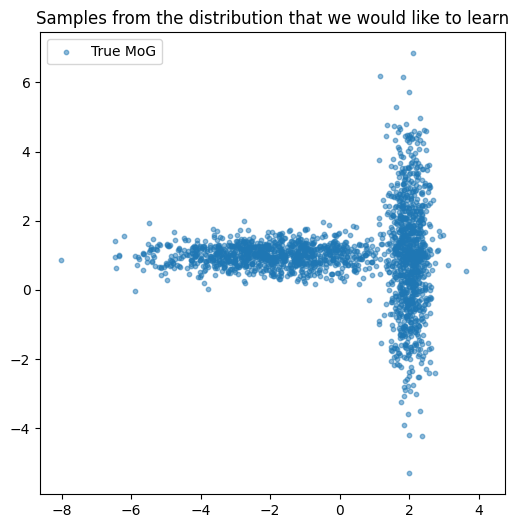

In [4]:
x_true, y_true = sample_mog2d(2000)

plt.figure(figsize=(6,6))
plt.scatter(x_true[:,0], x_true[:,1], alpha=0.5, label="True MoG", s=10)
plt.title("Samples from the distribution that we would like to learn")
plt.legend()
plt.show()


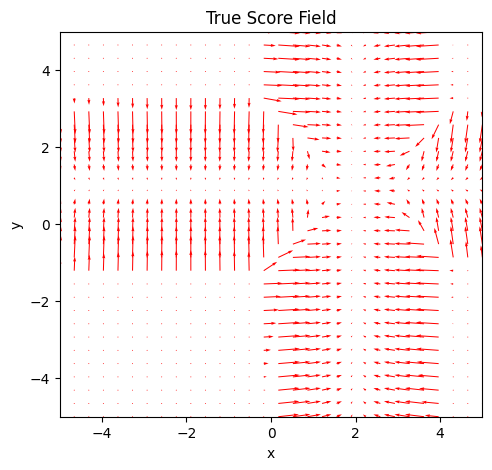

In [5]:
U,V=visualization_score(true_score,only_true=True)


##Dynamics Sampling

Langevin dynamics is a stochastic process that combines *gradient ascent*
on the log-probability with random noise.

The continuous form:

$dx_t = \frac{1}{2} \nabla_x \log p(x_t)\,dt + dW_t$

The discretized update used in sampling:

$x_{t+1} = x_t + \frac{\epsilon}{2}\nabla_x \log p(x_t) + \sqrt{\epsilon}\,z_t, \quad z_t\sim N(0,I)$

Intuition:

- Gradient term: moves points toward high-probability regions  
- Noise term: keeps exploration

In this case, the score is estimated by the model.

In [6]:
def langevin_sampling_2d(model, n_samples=2000, n_steps=300, eps=0.02):
  """
    Langevin sampling in 2D.

    model: a callable that takes x -> score(x) (torch.Tensor -> torch.Tensor of shape [n_samples, 2])
    n_samples: number of particles
    n_steps: total Langevin steps
    eps: step size
  """

  x = torch.randn(n_samples, 2)  # init from standard normal
  for t in range(n_steps):
    with torch.no_grad():
      score = model(x)
    noise = torch.randn_like(x)
    x = x + 0.5 * eps * score + torch.sqrt(torch.tensor(eps)) * noise
  return x



def langevin_sampling_2d_with_trajectory (model, n_samples=2000, n_steps=300, eps=0.02, record_every=5, n_traj_to_plot=100):
    """
    Langevin sampling in 2D with trajectory recording and visualization.

    model: a callable that takes x -> score(x) (torch.Tensor -> torch.Tensor of shape [n_samples, 2])
    n_samples: number of particles
    n_steps: total Langevin steps
    eps: step size
    record_every: how often to record intermediate positions (for plotting)
    n_traj_to_plot: number of trajectories to visualize
    """
    x = torch.randn(n_samples, 2)  # initialize from standard normal
    traj = [x.clone()]       # store initial positions

    for t in range(n_steps):
        with torch.no_grad():
            score = model(x)
        noise = torch.randn_like(x)
        x = x + 0.5 * eps * score + torch.sqrt(torch.tensor(eps)) * noise

        if (t + 1) % record_every == 0:
            traj.append(x.clone())

    traj = torch.stack(traj)  # shape (n_records, n_samples, 2)

    # ---- Visualization ----
    plt.figure(figsize=(8, 8))

    # Plot trajectories for a subset
    n_plot = min(traj.shape[1], n_traj_to_plot)
    for i in range(n_plot):
        plt.plot(traj[:, i, 0], traj[:, i, 1], lw=0.5, alpha=0.3, color='gray')

    # Start and end points
    plt.scatter(traj[0, :n_plot, 0], traj[0, :n_plot, 1], color='blue', s=10, label='start (x₀)')
    plt.scatter(x[:n_plot, 0], x[:n_plot, 1], color='orange', s=10, label='end ($x_T$)')

    plt.title("Langevin Sampling Trajectories (2D)")
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.legend()
    plt.axis('equal')
    plt.show()
    return x, traj

Q1. Write the functions euler_sampling_2d and euler_sampling_2d_with_trajectory as langevin_sampling without the stochastic component.

In [7]:
def euler_sampling_2d(model, n_samples=2000, n_steps=300, eps=0.02):
  """
    Euler sampling in 2D.

    model: a callable that takes x -> score(x) (torch.Tensor -> torch.Tensor of shape [n_samples, 2])
    n_samples: number of particles
    n_steps: total Langevin steps
    eps: step size
  """

  x = torch.randn(n_samples, 2)  # init from standard normal
  for t in range(n_steps):
    with torch.no_grad():
      score = model(x)
    x = x + eps * score
  return x

def euler_sampling_2d_with_trajectory (model, n_samples=2000, n_steps=300, eps=0.02, record_every=5, n_traj_to_plot=100):
    """
    Langevin sampling in 2D with trajectory recording and visualization.

    model: a callable that takes x -> score(x) (torch.Tensor -> torch.Tensor of shape [n_samples, 2])
    n_samples: number of particles
    n_steps: total Langevin steps
    eps: step size
    record_every: how often to record intermediate positions (for plotting)
    n_traj_to_plot: number of trajectories to visualize
    """
    x = torch.randn(n_samples, 2)  # initialize from standard normal
    traj = [x.clone()]       # store initial positions

    for t in range(n_steps):
        with torch.no_grad():
            score = model(x)
        x = x + eps * score

        if (t + 1) % record_every == 0:
            traj.append(x.clone())

    traj = torch.stack(traj)  # shape (n_records, n_samples, 2)

    # ---- Visualization ----
    plt.figure(figsize=(8, 8))

    # Plot trajectories for a subset
    n_plot = min(traj.shape[1], n_traj_to_plot)
    for i in range(n_plot):
        plt.plot(traj[:, i, 0], traj[:, i, 1], lw=0.5, alpha=0.3, color='gray')

    # Start and end points
    plt.scatter(traj[0, :n_plot, 0], traj[0, :n_plot, 1], color='blue', s=10, label='start (x₀)')
    plt.scatter(x[:n_plot, 0], x[:n_plot, 1], color='orange', s=10, label='end ($x_T$)')

    plt.title("Euler Sampling Trajectories (2D)")
    plt.xlabel("x₁")
    plt.ylabel("x₂")
    plt.legend()
    plt.axis('equal')
    plt.show()
    return x, traj

The results of Langevin sampling in the case where the score function is known are presented below.

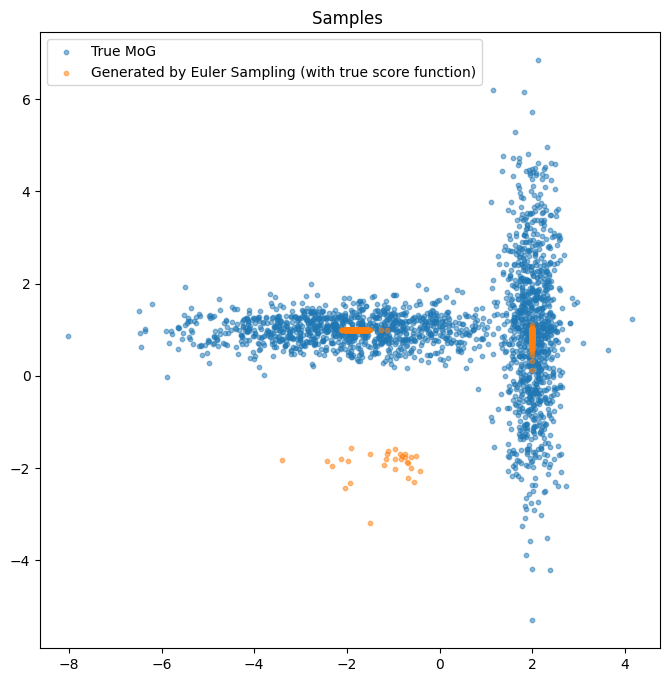

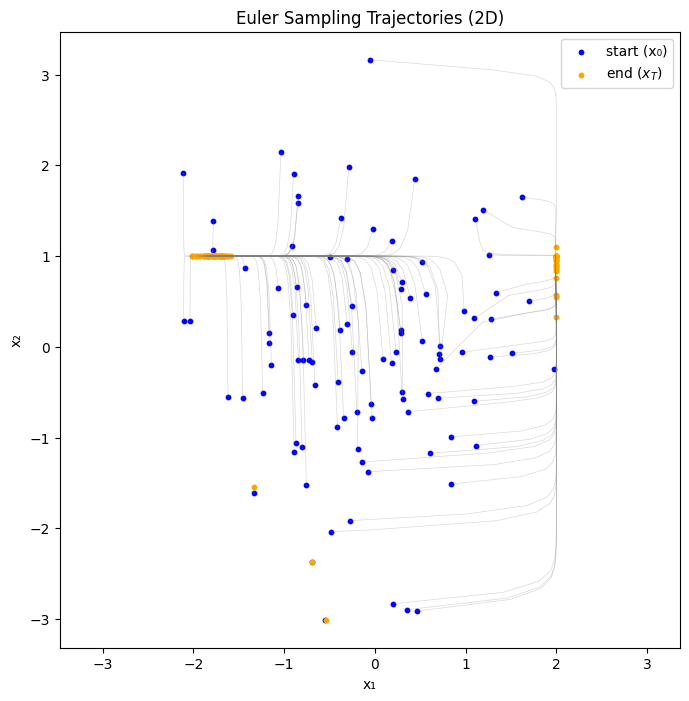

In [8]:
samples = euler_sampling_2d(true_score)
plt.figure(figsize=(8,8))
plt.scatter(x_true[:,0], x_true[:,1], alpha=0.5, label="True MoG", s=10)
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, label="Generated by Euler Sampling (with true score function)", s=10)
plt.title("Samples ")
plt.legend()
plt.show()

samples, traj = euler_sampling_2d_with_trajectory(true_score,n_traj_to_plot=100)

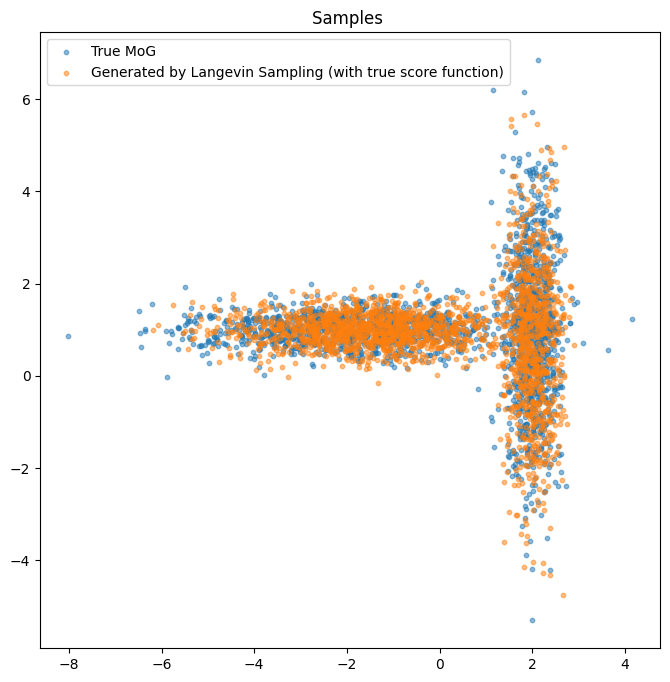

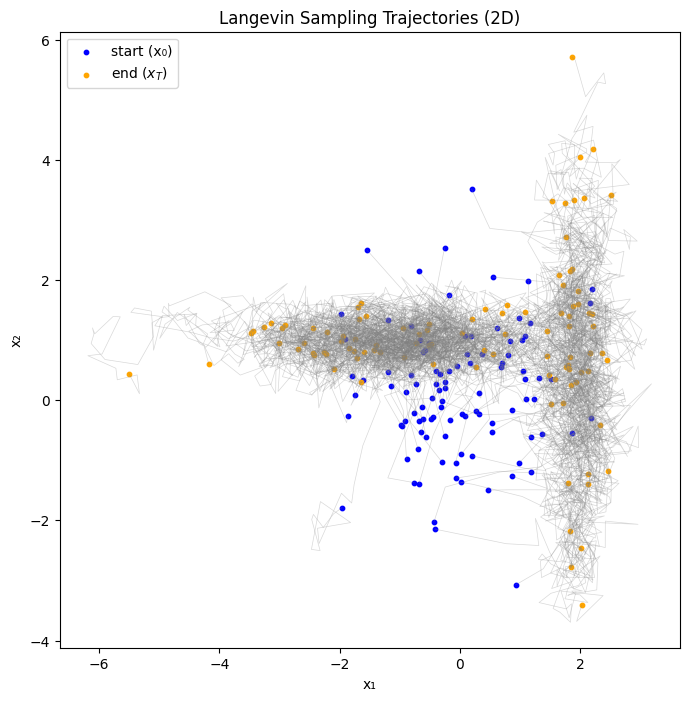

In [9]:
samples = langevin_sampling_2d(true_score)

plt.figure(figsize=(8,8))
plt.scatter(x_true[:,0], x_true[:,1], alpha=0.5, label="True MoG", s=10)
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, label="Generated by Langevin Sampling (with true score function)", s=10)
plt.title("Samples ")
plt.legend()
plt.show()

samples, traj = langevin_sampling_2d_with_trajectory(true_score)

We created a model to estimate the score function.

In [10]:
class ScoreNet2D(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 128),
            nn.Tanh(),
            nn.Linear(128, 128),
            nn.Tanh(),
            nn.Linear(128, 2)
        )
    def forward(self, x):
        return self.net(x)


In [11]:
model_Score = ScoreNet2D().to(device)
optimizer = optim.Adam(model_Score.parameters(), lr=lr)

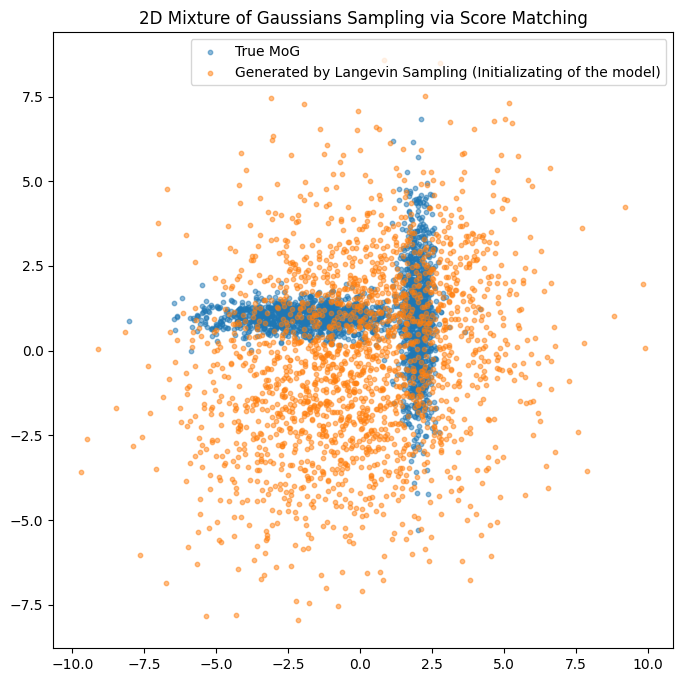

In [12]:
# True vs generated samples (scatter plot)
samples = langevin_sampling_2d(model_Score)

plt.figure(figsize=(8,8))
plt.scatter(x_true[:,0], x_true[:,1], alpha=0.5, label="True MoG", s=10)
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, label="Generated by Langevin Sampling (Initializating of the model)", s=10)
plt.title("2D Mixture of Gaussians Sampling via Score Matching")
plt.legend()
plt.show()


#samples, traj = langevin_sampling_2d_with_trajectory(model_Score)



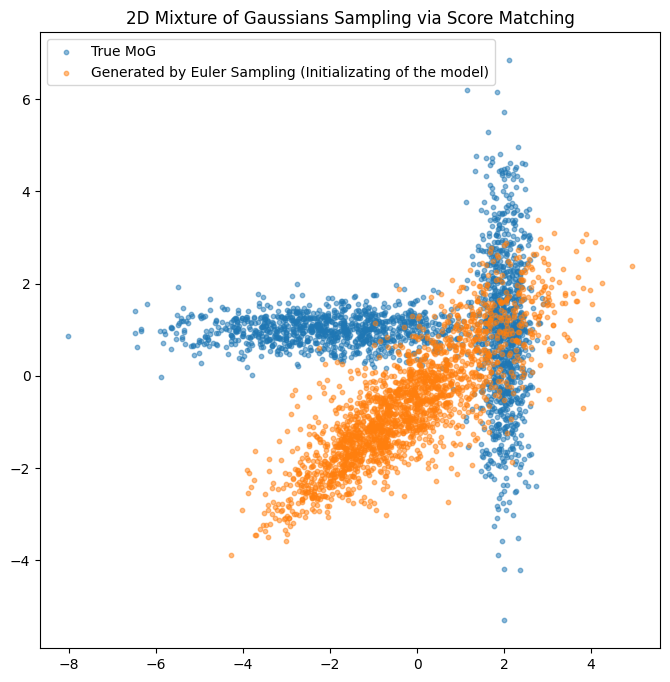

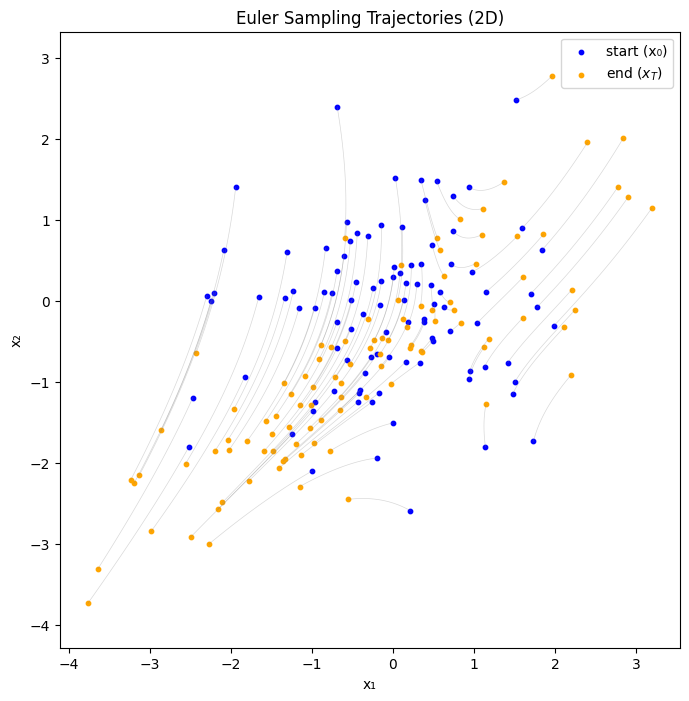

In [13]:
samples = euler_sampling_2d(model_Score)

plt.figure(figsize=(8,8))
plt.scatter(x_true[:,0], x_true[:,1], alpha=0.5, label="True MoG", s=10)
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, label="Generated by Euler Sampling (Initializating of the model)", s=10)
plt.title("2D Mixture of Gaussians Sampling via Score Matching")
plt.legend()
plt.show()


samples, traj = euler_sampling_2d_with_trajectory(model_Score,n_samples=10000)


In [14]:
epochs = 3000
batch_size = 512
sigma = 0.5  # noise level
losses = []

Training for a denoising score-matching (DSM) model:


We want to train a neural network model(x) to approximate the score function:
$
s_{\theta}(x)≈ ∇_x log p_{data}(x)
$

However, in general cases, the directly computing that gradient from samples is impossible, because we only have data samples from $p_{data}(x)$.

Accordingly, denoising score matching (DSM) corrupts data with noise, and teach the model to predict how to remove that noise.

In [15]:
for epoch in range(epochs):
    x,y = sample_mog2d(batch_size)
    noise = torch.randn_like(x) * sigma
    x_tilde = x + noise

    target = - noise / (sigma**2)  # denoising target
    score_pred = model_Score(x_tilde)

    loss = 0.5 * torch.mean((score_pred - target)**2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if (epoch+1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {loss.item():.4f}")

Epoch [500/3000] Loss: 1.4245
Epoch [1000/3000] Loss: 1.2768
Epoch [1500/3000] Loss: 1.3414
Epoch [2000/3000] Loss: 1.3621
Epoch [2500/3000] Loss: 1.2675
Epoch [3000/3000] Loss: 1.2383


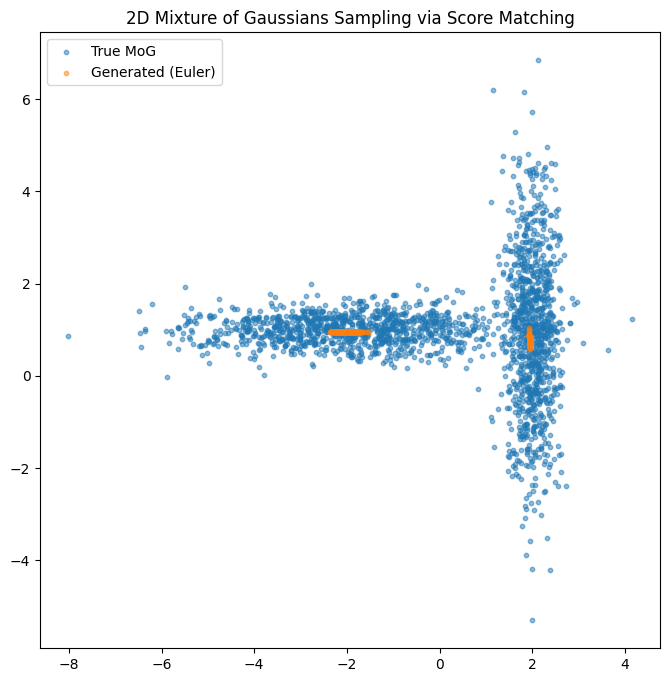

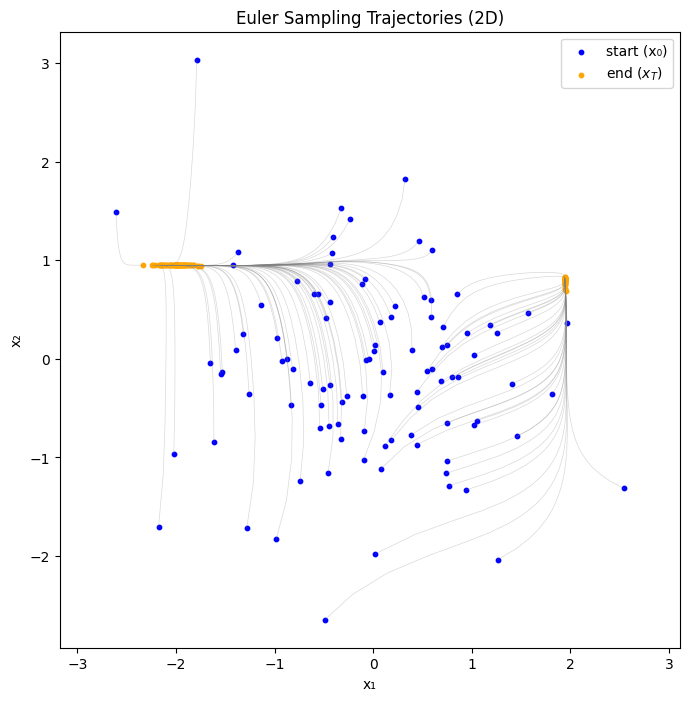

In [16]:
# True vs generated samples (scatter plot)
samples = euler_sampling_2d(model_Score)

plt.figure(figsize=(8,8))
plt.scatter(x_true[:,0], x_true[:,1], alpha=0.5, label="True MoG", s=10)
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, label="Generated (Euler)", s=10)
plt.title("2D Mixture of Gaussians Sampling via Score Matching")
plt.legend()
plt.show()

samples, traj = euler_sampling_2d_with_trajectory(model_Score)

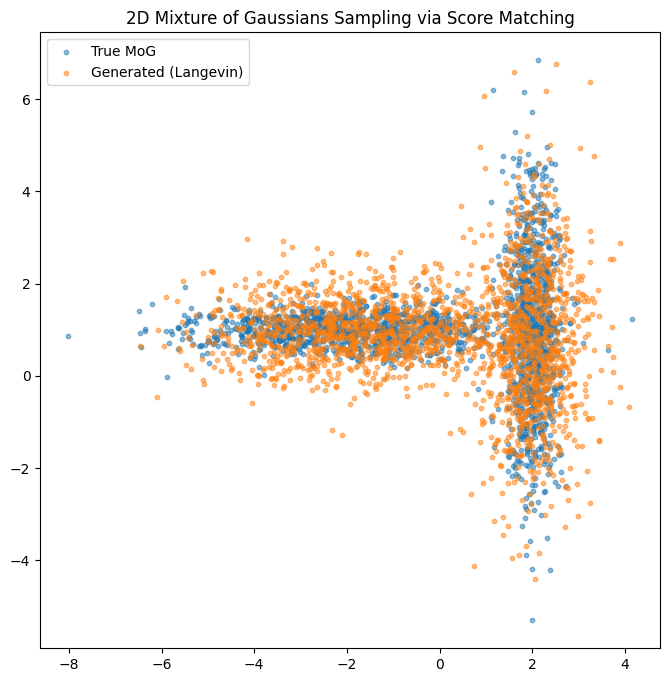

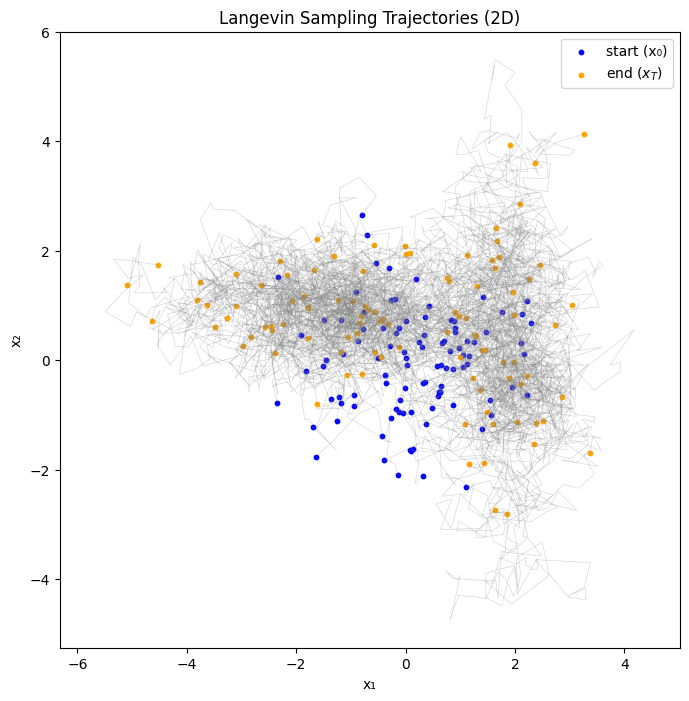

In [17]:
# True vs generated samples (scatter plot)
samples = langevin_sampling_2d(model_Score)

plt.figure(figsize=(8,8))
plt.scatter(x_true[:,0], x_true[:,1], alpha=0.5, label="True MoG", s=10)
plt.scatter(samples[:,0], samples[:,1], alpha=0.5, label="Generated (Langevin)", s=10)
plt.title("2D Mixture of Gaussians Sampling via Score Matching")
plt.legend()
plt.show()

samples, traj = langevin_sampling_2d_with_trajectory(model_Score)

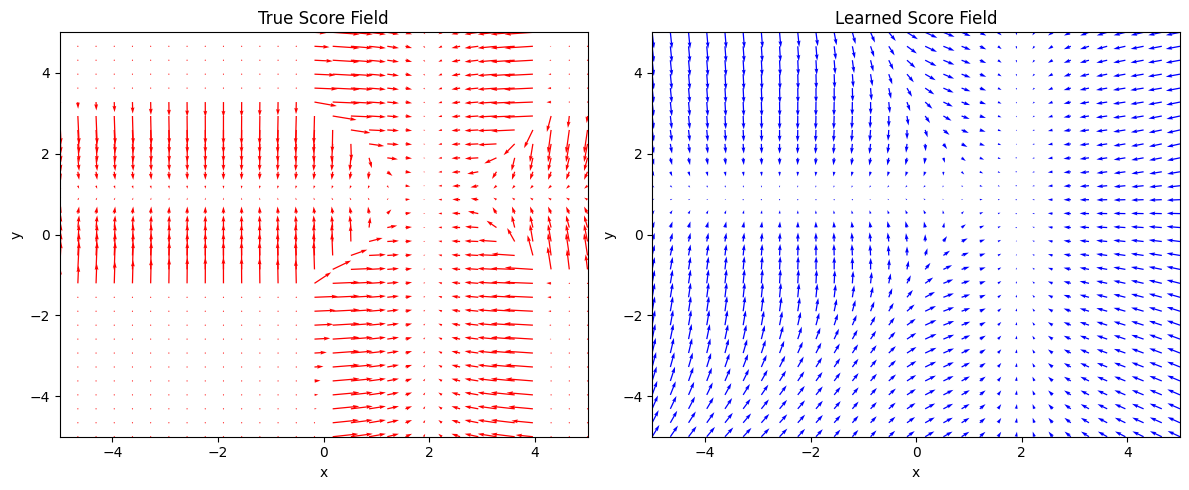

In [18]:
U,V=visualization_score(model_Score)

**Q2**:  Visualize the generation by langevin_sampling with epsilon=1e-5 and epsilon=1. What can you say about the effect of this generation parameter?

**Answer:**

Small $ϵ$ (1e-5): This leads to small step sizes, making learning slow. The samples probably would not fully cover the distribution within the allowed steps, which can cause them to get stuck in local areas. However, this choice offers more accurate following of gradients.

Large $ϵ$ (1.0): This results in bigger step sizes, allowing for faster movement through the space but adding more error in approximations. The noise becomes more significant, leading to more exploration but possibly missing the target distribution. This can produce less accurate samples but helps cover different modes better.

We should choose $ϵ$ to find a balance between exploring and exploiting the space.

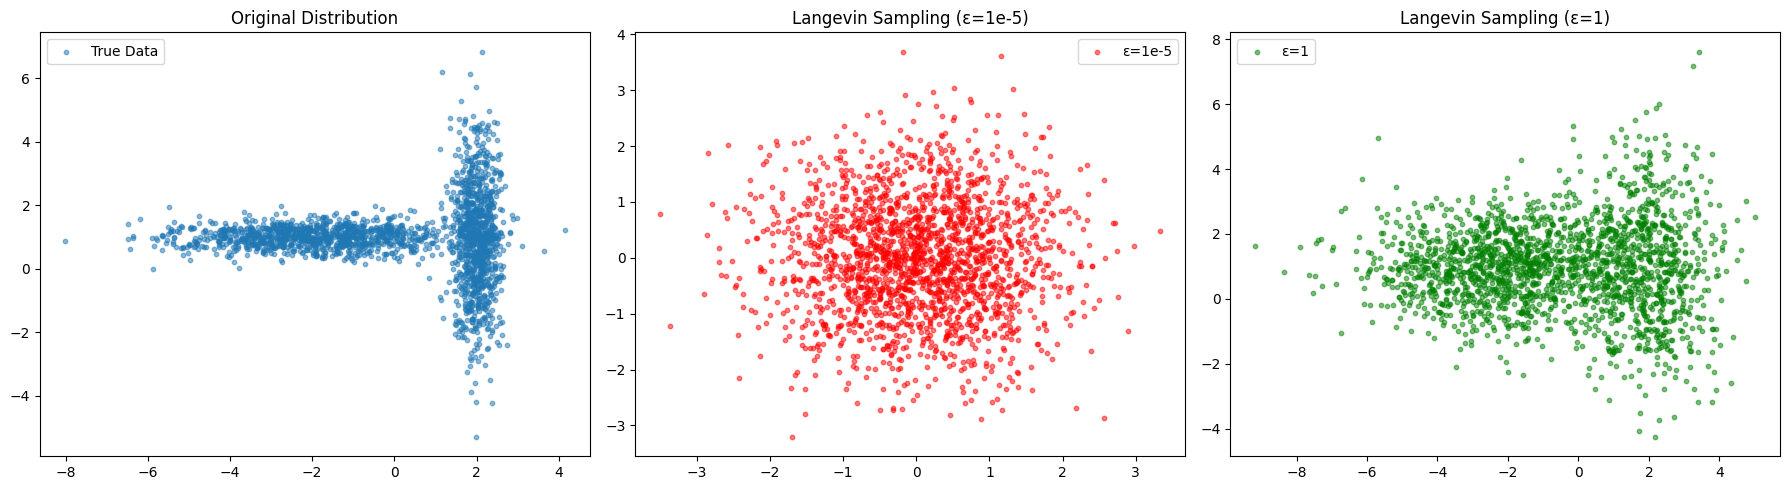

In [19]:
# Generate samples with different epsilon values
x_generated_small = langevin_sampling_2d(model_Score, n_samples=2000, n_steps=1000,
                                         eps=1e-5)
x_generated_large = langevin_sampling_2d(model_Score, n_samples=2000, n_steps=1000,
                                         eps=1.0)

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Original data
axes[0].scatter(x_true[:, 0], x_true[:, 1], alpha=0.5, s=10, label='True Data')
axes[0].set_title('Original Distribution')
axes[0].legend()

# Epsilon = 1e-5
axes[1].scatter(x_generated_small[:, 0], x_generated_small[:, 1],
                alpha=0.5, s=10, color='red', label='ε=1e-5')
axes[1].set_title('Langevin Sampling (ε=1e-5)')
axes[1].legend()

# Epsilon = 1
axes[2].scatter(x_generated_large[:, 0], x_generated_large[:, 1],
                alpha=0.5, s=10, color='green', label='ε=1')
axes[2].set_title('Langevin Sampling (ε=1)')
axes[2].legend()

plt.tight_layout()
plt.show()



**Annealed Langevin Dynamics** (ALD) introduces a temperature (or noise) schedule to help the sampler explore the space more effectively.
It samples progressively from noisy to clean distributions: starting easy, then refining.

In [20]:
# --- Example MLP score network ---
class ScoreNetSigma(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=128):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim + 1, hidden_dim),  # +1 for sigma input
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim)
        )
    def forward(self, x, sigma):
      # x: [batch_size, 2]
      # sigma: scalar or tensor of shape [batch_size]

      if sigma.dim() == 0:  # scalar
          sigma_feature = sigma.expand(x.shape[0], 1)  # [batch_size,1]
      elif sigma.dim() == 1:  # already batch of sigmas
          sigma_feature = sigma.reshape(-1, 1)        # [batch_size,1]
      else:
          raise ValueError("sigma must be scalar or 1D tensor")

      inp = torch.cat([x, sigma_feature], dim=1)      # [batch_size, 3]
      return self.net(inp)

In [21]:
# --- Training hyperparameters ---
sigmas = torch.exp(torch.linspace(torch.log(torch.tensor(1.0)), torch.log(torch.tensor(0.05)), 10))
print(sigmas)


tensor([1.0000, 0.7169, 0.5139, 0.3684, 0.2641, 0.1893, 0.1357, 0.0973, 0.0697,
        0.0500])


In [22]:
model_ScoreSigma = ScoreNetSigma().to(device)
optimizer = optim.Adam(model_ScoreSigma.parameters(), lr=lr)
losses = []


In [23]:
# --- Training loop (annealed DSM) ---
for epoch in range(epochs):
    x,y = sample_mog2d(batch_size)

    # Sample a sigma for each sample from the schedule
    sigma = sigmas[torch.randint(0, len(sigmas), (batch_size,))].to(device)

    # Add Gaussian noise
    noise = torch.randn_like(x) * sigma.view(-1, 1)
    x_tilde = x + noise

    # Denoising target
    target = - noise / (sigma.view(-1,1)**2)

    # Forward pass
    score_pred = model_ScoreSigma(x_tilde, sigma)

    # MSE loss
    loss = 0.5 * torch.mean((score_pred - target)**2)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    if (epoch+1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {loss.item():.4f}")

Epoch [500/3000] Loss: 39.0429
Epoch [1000/3000] Loss: 39.4292
Epoch [1500/3000] Loss: 36.9407
Epoch [2000/3000] Loss: 39.8557
Epoch [2500/3000] Loss: 44.3604
Epoch [3000/3000] Loss: 40.7227


In [24]:
# --- Annealed Langevin dynamics sampler
def langevin_sampling_annealed(model, n_samples=1000, n_steps_each=50,
                               sigma_min=0.05, sigma_max=1.0, n_sigmas=10,
                               eps_coeff=0.1, device="cpu"):
    """
    Generate samples using annealed Langevin dynamics.
    model: score network s_theta(x, sigma)
    eps_coeff: step size = eps_coeff * sigma^2
    """
    # Log-spaced noise schedule
    sigmas = torch.exp(torch.linspace(torch.log(torch.tensor(sigma_max)),
                                      torch.log(torch.tensor(sigma_min)),
                                      n_sigmas)).to(device)

    # Initialize from Gaussian noise
    x = torch.randn(n_samples, 2, device=device) * sigma_max

    # Loop over noise levels
    for sigma in sigmas:
        eps = eps_coeff * sigma**2
        for _ in range(n_steps_each):
            z = torch.randn_like(x)
            with torch.no_grad():
              score = model(x, sigma)
            x = x + 0.5 * eps * score + torch.sqrt(eps) * z

    return x

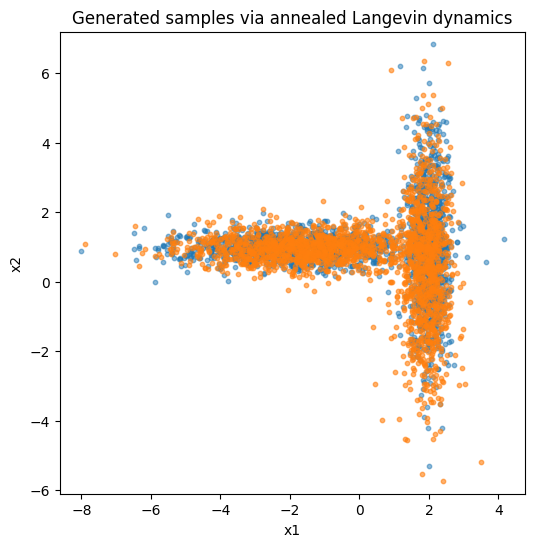

In [25]:
# Generate 2000 samples
samples = langevin_sampling_annealed(model_ScoreSigma, n_samples=2000, n_steps_each=50,
                                     sigma_min=0.05, sigma_max=1.0, n_sigmas=10,
                                     eps_coeff=0.1, device="cpu")

# Plot the generated 2D samples
import matplotlib.pyplot as plt

plt.figure(figsize=(6,6))
plt.scatter(x_true[:,0], x_true[:,1], alpha=0.5, label="True MoG", s=10)
plt.scatter(samples[:,0], samples[:,1], s=10, alpha=0.6)
plt.title("Generated samples via annealed Langevin dynamics")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

**Q3**: Create a function to visualise the field of the score function for different values of sigma.

In [26]:
def visualization_score_annealed(model,sigma,only_true=False):
  #This code visualize the 2D prediction of the model as a field.
  # Create a 2D grid for visualization
  x_vals = np.linspace(-5, 5, 30)
  y_vals = np.linspace(-5, 5, 30)
  X, Y = np.meshgrid(x_vals, y_vals)
  grid = torch.tensor(np.stack([X.flatten(), Y.flatten()], axis=1), dtype=torch.float32)

  # Compute true score
  score_true_grid = true_score(grid).numpy()
  U_true = score_true_grid[:,0].reshape(X.shape)
  V_true = score_true_grid[:,1].reshape(Y.shape)

  # Compute learned score
  with torch.no_grad():
      score_learned_grid = model(grid, torch.tensor(sigma)).numpy()
  U_learned = score_learned_grid[:,0].reshape(X.shape)
  V_learned = score_learned_grid[:,1].reshape(Y.shape)

  # Plot true score
  plt.figure(figsize=(12,5))
  plt.subplot(1,2,1)
  plt.quiver(X, Y, U_true, V_true, color='r')
  plt.title("True Score Field")
  plt.xlabel("x")
  plt.ylabel("y")
  plt.xlim(-5,5)
  plt.ylim(-5,5)

  if only_true:
    return U_learned,V_learned
  else:
    # Plot learned score
    plt.subplot(1,2,2)
    plt.quiver(X, Y, U_learned, V_learned, color='b')
    plt.title("Learned Score Field (Sigma="+str(sigma)+")")
    plt.xlabel("x")
    plt.ylabel("y")
    plt.xlim(-5,5)
    plt.ylim(-5,5)
  plt.tight_layout()
  plt.show()
  return U_learned,V_learned

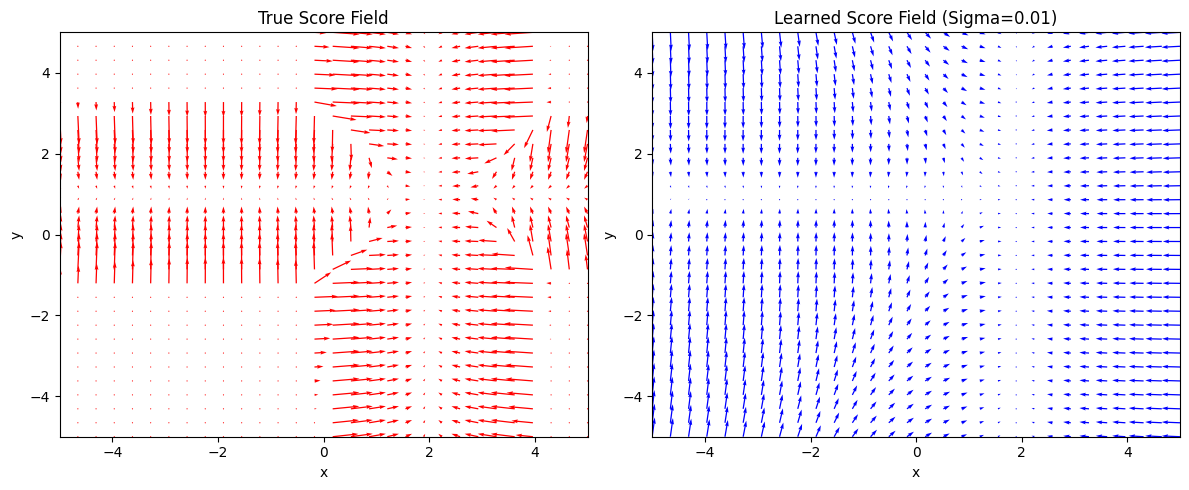

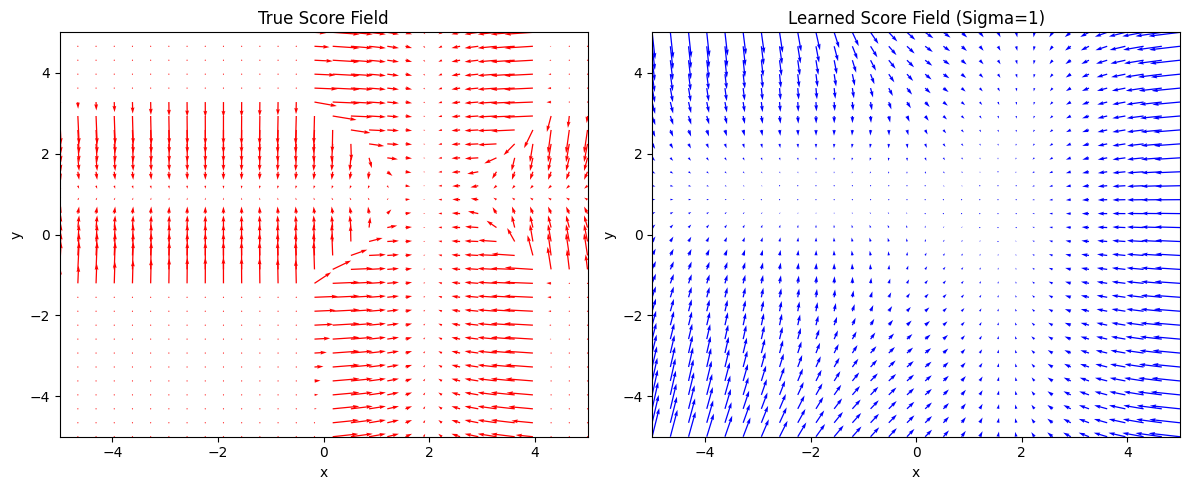

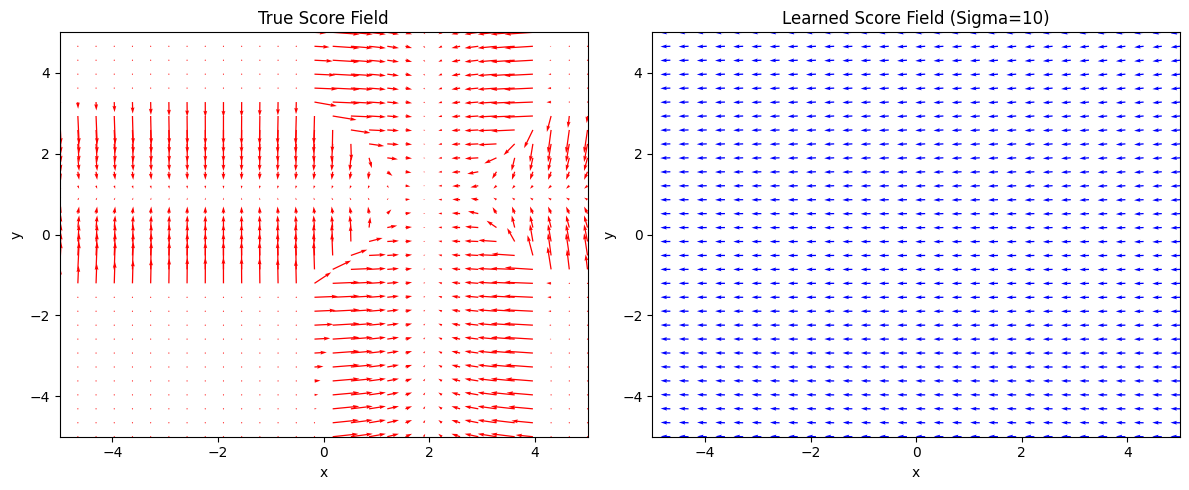

In [27]:
U,V=visualization_score_annealed(model_ScoreSigma,0.01)
U,V=visualization_score_annealed(model_ScoreSigma,1)
U,V=visualization_score_annealed(model_ScoreSigma,10)

**Questions**

**Q4**. Compare denoising score matching model generate by Langevin and Annealed Langevin using:


a. Maximum Mean Discrepancy for a Gaussian kernel with different value value of sigma (parameter of the kernel)

b. Wasserstein distance between generated and original data set. Use for instance (https://pythonot.github.io/)


c. Precision/Recall Curve (by varying k-value)

Precision: How many generated samples fall on near the true data "manifold"?
Recall: How much of the true data "manifold" is covered by the generated samples?
We approximate “on/near the manifold” using k-nearest neighbor distances.

###
1. Compute distance from each generated sample to its k-th nearest generated neighbor to get R_gen.

2. For each real sample, compute its distance to its k nearest generated neighbors.

3. If the distance to the k-th nearest generated neighbor $\leq R_gen$, we say the real sample is "covered by generated samples".

4. We use as "Recall" the fraction of real samples that are covered by the generated.

In the symmetric way, we define "Precision", the fraction of generated data that are covered by the real samples.

With that two measures, we can define a F1-score.

####


**Q5**. Generate noisy version of the dataset 2D Mixture of Gaussians by adding Gaussian noise at three different levels: small, medium, and large.

For each noise level, compute the precision, recall, and F1 score between the real data (x_real) and the noisy samples using k-NN evaluation.
Vary the number of neighbors k from 1 to 20, plot the resulting curves for each noise level, and explain how noise affects the precision, recall, and F1 metrics.

**Q6**

In the definition of Maximum Mean Discrepancy (MMD) suppose that the kernel is linear. Derive a simplified expression for MMD in this case. Interpret this result.

**Q7**

Train two generative models in the following example of a S-shape dataset. Compare the results.










Q4 Answer

In [28]:
!pip install pot
import ot
from scipy.spatial.distance import cdist
from sklearn.neighbors import NearestNeighbors

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 22.8 MB/s eta 0:00:00


In [29]:
n_samples = x_true.shape[0]

# Generate from the single-sigma model using Langevin sampling
samples_langevin = langevin_sampling_2d(model_Score, n_samples=n_samples, n_steps=300, eps=0.02).cpu().numpy()

# Generate from the annealed model using annealed sampling
samples_annealed = langevin_sampling_annealed(model_ScoreSigma, n_samples=n_samples, n_steps_each=50,
                                             sigma_min=0.05, sigma_max=1.0, n_sigmas=10,
                                             eps_coeff=0.1, device="cpu").cpu().numpy()

# Convert x_true to numpy
x_true_np = x_true.cpu().numpy()

print(f"Data shapes for comparison:")
print(f"True data (x_true):     {x_true_np.shape}")
print(f"Langevin samples:   {samples_langevin.shape}")
print(f"Annealed samples: {samples_annealed.shape}")

Data shapes for comparison:
True data (x_true):     (2000, 2)
Langevin samples:   (2000, 2)
Annealed samples: (2000, 2)


Kernel Sigma = 0.1
  MMD (Langevin):   0.001881
  MMD (Annealed):   0.001255
Kernel Sigma = 0.5
  MMD (Langevin):   0.007803
  MMD (Annealed):   0.004611
Kernel Sigma = 1.0
  MMD (Langevin):   0.005543
  MMD (Annealed):   0.007228
Kernel Sigma = 2.0
  MMD (Langevin):   0.002829
  MMD (Annealed):   0.007031
Kernel Sigma = 5.0
  MMD (Langevin):   0.000715
  MMD (Annealed):   0.002432


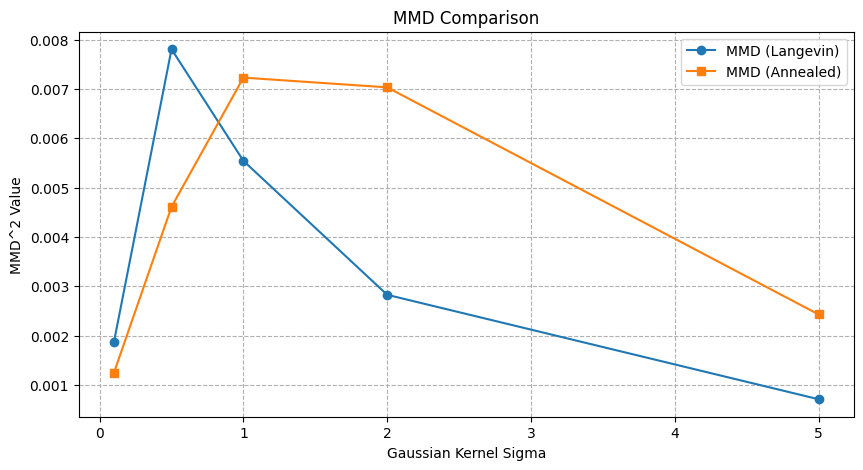

In [30]:
def gaussian_kernel(x, y, sigma=1.0):
    """ Computes the RBF kernel matrix between x and y. """
    gamma = 1.0 / (2 * sigma**2)
    if not isinstance(x, torch.Tensor): x = torch.tensor(x, dtype=torch.float32)
    if not isinstance(y, torch.Tensor): y = torch.tensor(y, dtype=torch.float32)

    dist_sq = torch.cdist(x, y, p=2)**2
    return torch.exp(-gamma * dist_sq)

def mmd_gaussian_kernel(x, y, sigma=1.0):
    """ Computes the MMD^2 between two sample sets x and y using a Gaussian kernel. """
    K_xx = gaussian_kernel(x, x, sigma).mean()
    K_yy = gaussian_kernel(y, y, sigma).mean()
    K_xy = gaussian_kernel(x, y, sigma).mean()
    return K_xx + K_yy - 2 * K_xy

# Kernel sigmas to test
kernel_sigmas = [0.1, 0.5, 1.0, 2.0, 5.0]

mmd_langevin = []
mmd_annealed = []

for sig in kernel_sigmas:
    mmd_l = mmd_gaussian_kernel(x_true_np, samples_langevin, sigma=sig).item()
    mmd_a = mmd_gaussian_kernel(x_true_np, samples_annealed, sigma=sig).item()
    mmd_langevin.append(mmd_l)
    mmd_annealed.append(mmd_a)
    print(f"Kernel Sigma = {sig:.1f}")
    print(f"  MMD (Langevin):   {mmd_l:.6f}")
    print(f"  MMD (Annealed):   {mmd_a:.6f}")

# Plotting MMD results
plt.figure(figsize=(10, 5))
plt.plot(kernel_sigmas, mmd_langevin, 'o-', label="MMD (Langevin)")
plt.plot(kernel_sigmas, mmd_annealed, 's-', label="MMD (Annealed)")
plt.title("MMD Comparison")
plt.xlabel("Gaussian Kernel Sigma")
plt.ylabel("MMD^2 Value")
plt.legend()
plt.grid(True, linestyle='--')
plt.show()

The Annealed model shows a lower MMD for all small to medium kernel sizes (0.1, 0.5, 1.0, and 2.0). These smaller sizes are better at detecting small, local differences between distributions. The Langevin model only performs better at a larger size of 5.0. At this size, the large kernel "blurs" the distributions, making it less sensitive to their details.

In [31]:
# Compute pairwise squared Euclidean cost matrix
cost_matrix_langevin = cdist(x_true_np, samples_langevin, metric='sqeuclidean')
cost_matrix_annealed = cdist(x_true_np, samples_annealed, metric='sqeuclidean')

# Uniform weights for both distributions
a = np.ones(n_samples) / n_samples
b = np.ones(n_samples) / n_samples

# Compute EMD (which is W_2^2 since we use sqeuclidean cost)
w2_langevin = ot.emd2(a, b, cost_matrix_langevin)
w2_annealed = ot.emd2(a, b, cost_matrix_annealed)

print(f"Wasserstein-2 Distance (Squared):")
print(f"  W_2^2 (Langevin):   {w2_langevin:.6f}")
print(f"  W_2^2 (Annealed):   {w2_annealed:.6f}")

Wasserstein-2 Distance (Squared):
  W_2^2 (Langevin):   0.155105
  W_2^2 (Annealed):   0.240094


This is an interesting finding. The Langevin model shows a lower Wasserstein-2 distance than the Annealed model. This means that it takes slightly less "geometric" effort to change the Langevin samples into the true distribution compared to the effort needed for the Annealed samples.

However, this presents a conflicting message because the MMD and P/R/F1 metrics indicate that the Annealed model is better.

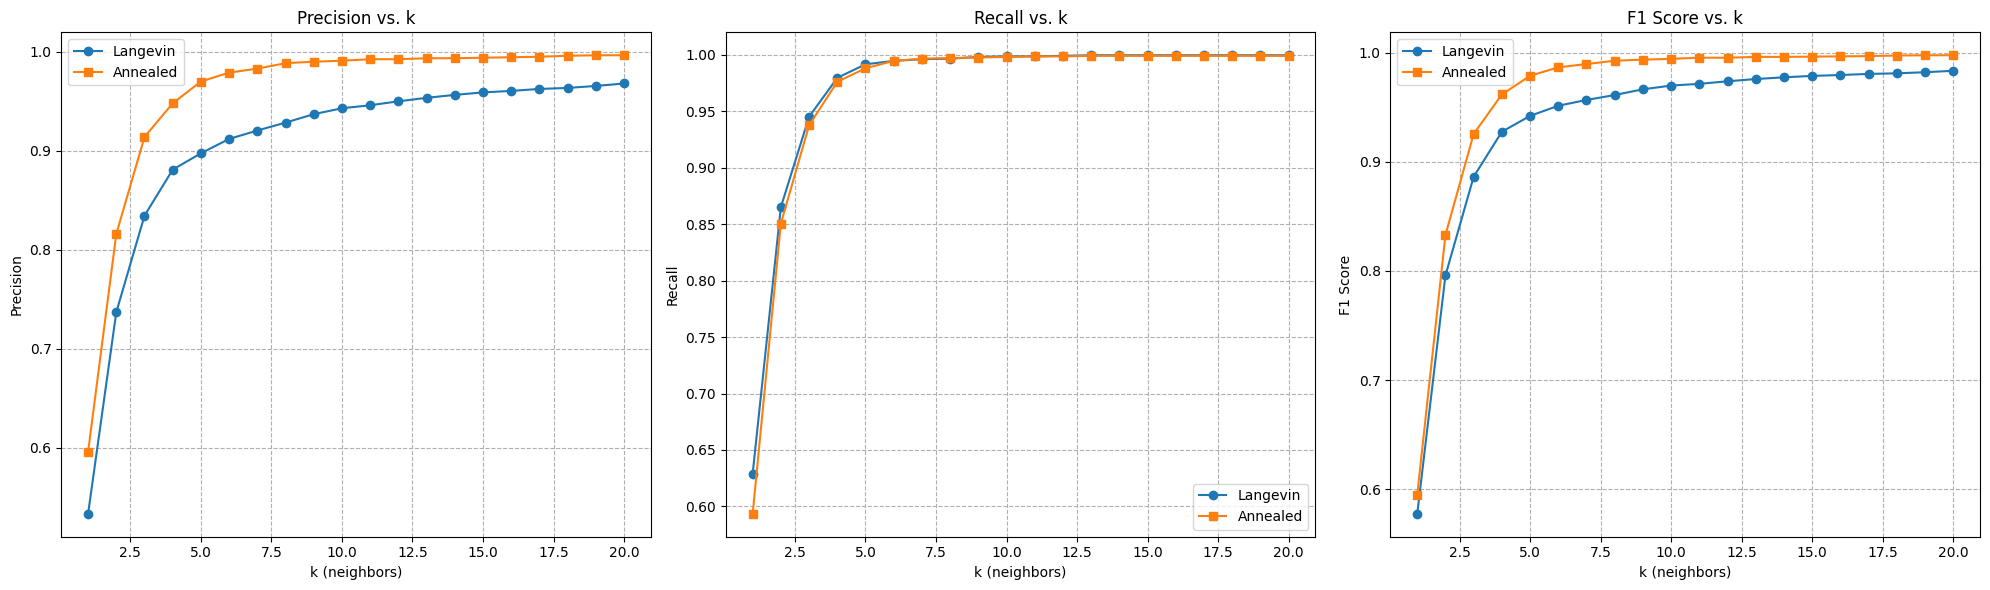

In [32]:
def compute_pr_f1(real_data, gen_data, k=5):
    """
    Computes k-NN based Precision, Recall, and F1-score.
    k: number of nearest neighbors
    """

    # Ensure data is numpy
    if isinstance(real_data, torch.Tensor): real_data = real_data.cpu().numpy()
    if isinstance(gen_data, torch.Tensor): gen_data = gen_data.cpu().numpy()

    # Get k-th NN radius for each REAL point (in the REAL set)
    nn_real = NearestNeighbors(n_neighbors=k + 1).fit(real_data)
    real_radii = nn_real.kneighbors(real_data)[0][:, k]

    # For each GEN point, find its 1-NN in the REAL set
    nn_real_1nn = NearestNeighbors(n_neighbors=1).fit(real_data)
    gen_to_real_dist, gen_to_real_idx = nn_real_1nn.kneighbors(gen_data)

    # Precision = % of gen points whose 1-NN dist <= k-NN radius of that real point
    precision = np.mean(gen_to_real_dist.ravel() <= real_radii[gen_to_real_idx.ravel()])

    # Get k-th NN radius for each GEN point (in the GEN set)
    nn_gen = NearestNeighbors(n_neighbors=k + 1).fit(gen_data)
    gen_radii = nn_gen.kneighbors(gen_data)[0][:, k]

    # For each REAL point, find its 1-NN in the GEN set
    nn_gen_1nn = NearestNeighbors(n_neighbors=1).fit(gen_data)
    real_to_gen_dist, real_to_gen_idx = nn_gen_1nn.kneighbors(real_data)

    # Recall = % of real points whose 1-NN dist <= k-NN radius of that gen point
    recall = np.mean(real_to_gen_dist.ravel() <= gen_radii[real_to_gen_idx.ravel()])

    f1 = 2 * (precision * recall) / (precision + recall + 1e-10)

    return precision, recall, f1

k_values = list(range(1, 21))
results_langevin = {'p': [], 'r': [], 'f1': []}
results_annealed = {'p': [], 'r': [], 'f1': []}

for k in k_values:
    p_l, r_l, f1_l = compute_pr_f1(x_true_np, samples_langevin, k=k)
    results_langevin['p'].append(p_l)
    results_langevin['r'].append(r_l)
    results_langevin['f1'].append(f1_l)

    p_a, r_a, f1_a = compute_pr_f1(x_true_np, samples_annealed, k=k)
    results_annealed['p'].append(p_a)
    results_annealed['r'].append(r_a)
    results_annealed['f1'].append(f1_a)

# Plotting P/R/F1 curves
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Precision
axes[0].plot(k_values, results_langevin['p'], 'o-', label="Langevin")
axes[0].plot(k_values, results_annealed['p'], 's-', label="Annealed")
axes[0].set_title("Precision vs. k")
axes[0].set_xlabel("k (neighbors)")
axes[0].set_ylabel("Precision")
axes[0].legend()
axes[0].grid(True, linestyle='--')

# Recall
axes[1].plot(k_values, results_langevin['r'], 'o-', label="Langevin")
axes[1].plot(k_values, results_annealed['r'], 's-', label="Annealed")
axes[1].set_title("Recall vs. k")
axes[1].set_xlabel("k (neighbors)")
axes[1].set_ylabel("Recall")
axes[1].legend()
axes[1].grid(True, linestyle='--')

# F1 Score
axes[2].plot(k_values, results_langevin['f1'], 'o-', label="Langevin")
axes[2].plot(k_values, results_annealed['f1'], 's-', label="Annealed")
axes[2].set_title("F1 Score vs. k")
axes[2].set_xlabel("k (neighbors)")
axes[2].set_ylabel("F1 Score")
axes[2].legend()
axes[2].grid(True, linestyle='--')

plt.tight_layout()
plt.show()

**Precision (Left Plot):** The Annealed model consistently shows higher precision than the standard Langevin model for all values of k. This means that more of the Annealed model's samples are considered "realistic," meaning they are close to the true data.

**Recall (Middle Plot):** Both models perform well and have nearly the same recall, quickly reaching nearly 100%. This indicates they both cover the true data distribution completely and do not miss any important parts.

**F1 Score (Right Plot):** The F1 score combines precision and recall. Since both models have high and similar recall, the F1 score mainly reflects precision. Therefore, the Annealed model has a much higher F1 score, showing its better sample quality.

**Q5 Answer**

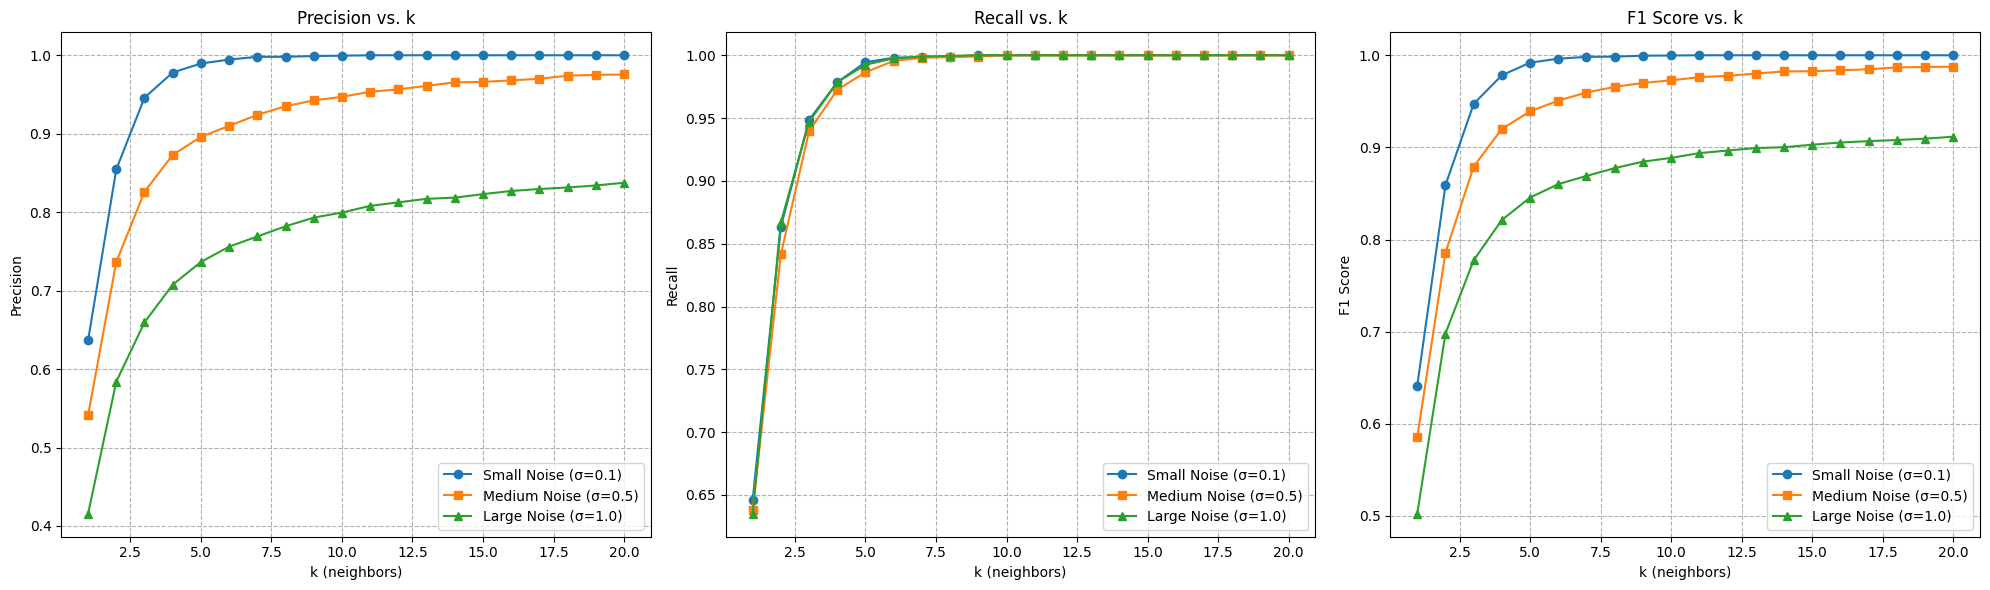

In [33]:
# Define noise levels
sigma_small = 0.1
sigma_medium = 0.5
sigma_large = 1.0

# Create noisy datasets
x_noisy_small = x_true_np + np.random.randn(*x_true_np.shape) * sigma_small
x_noisy_medium = x_true_np + np.random.randn(*x_true_np.shape) * sigma_medium
x_noisy_large = x_true_np + np.random.randn(*x_true_np.shape) * sigma_large

# Store results
k_values = list(range(1, 21))
results = {
    'small': {'p': [], 'r': [], 'f1': []},
    'medium': {'p': [], 'r': [], 'f1': []},
    'large': {'p': [], 'r': [], 'f1': []}
}

# Compute metrics
for k in k_values:
    p_s, r_s, f1_s = compute_pr_f1(x_true_np, x_noisy_small, k=k)
    results['small']['p'].append(p_s)
    results['small']['r'].append(r_s)
    results['small']['f1'].append(f1_s)

    p_m, r_m, f1_m = compute_pr_f1(x_true_np, x_noisy_medium, k=k)
    results['medium']['p'].append(p_m)
    results['medium']['r'].append(r_m)
    results['medium']['f1'].append(f1_m)

    p_l, r_l, f1_l = compute_pr_f1(x_true_np, x_noisy_large, k=k)
    results['large']['p'].append(p_l)
    results['large']['r'].append(r_l)
    results['large']['f1'].append(f1_l)

# Plotting P/R/F1 curves
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Precision
axes[0].plot(k_values, results['small']['p'], 'o-', label="Small Noise (σ=0.1)")
axes[0].plot(k_values, results['medium']['p'], 's-', label="Medium Noise (σ=0.5)")
axes[0].plot(k_values, results['large']['p'], '^-', label="Large Noise (σ=1.0)")
axes[0].set_title("Precision vs. k")
axes[0].set_xlabel("k (neighbors)")
axes[0].set_ylabel("Precision")
axes[0].legend()
axes[0].grid(True, linestyle='--')

# Recall
axes[1].plot(k_values, results['small']['r'], 'o-', label="Small Noise (σ=0.1)")
axes[1].plot(k_values, results['medium']['r'], 's-', label="Medium Noise (σ=0.5)")
axes[1].plot(k_values, results['large']['r'], '^-', label="Large Noise (σ=1.0)")
axes[1].set_title("Recall vs. k")
axes[1].set_xlabel("k (neighbors)")
axes[1].set_ylabel("Recall")
axes[1].legend()
axes[1].grid(True, linestyle='--')

# F1 Score
axes[2].plot(k_values, results['small']['f1'], 'o-', label="Small Noise (σ=0.1)")
axes[2].plot(k_values, results['medium']['f1'], 's-', label="Medium Noise (σ=0.5)")
axes[2].plot(k_values, results['large']['f1'], '^-', label="Large Noise (σ=1.0)")
axes[2].set_title("F1 Score vs. k")
axes[2].set_xlabel("k (neighbors)")
axes[2].set_ylabel("F1 Score")
axes[2].legend()
axes[2].grid(True, linestyle='--')

plt.tight_layout()
plt.show()



**Precision:**

Precision decreases significantly as the noise level increases. The line for "Small Noise" ($\sigma=0.1$) is the highest, while the "Large Noise" ($\sigma=1.0$) line is the lowest.
Precision tells us what fraction of the noisy samples are close to the real data. When we add more noise, the noisy points move further away from their original locations. As a result, fewer of these noisy points end up close enough to the real data to be considered precise, which causes this metric to drop.

**Recall:**

Recall is very high (close to 1.0) for all noise levels. The lines stay clustered at the top.
Recall measures what fraction of the real data is included in the noisy data. Adding noise spreads out the data, making its overall shape larger. This larger noisy shape easily includes all the points from the original, clean data. Therefore, recall remains high.

**F1 Score:**

The F1 score plot looks similar to the Precision plot. The F1 score drops as noise increases.
The F1 score combines Precision and Recall. Since Recall is high and doesn't change much (about 1.0 for all noise levels), the F1 score mainly depends on Precision. Thus, the drop in F1 score reflects the drop in Precision caused by the increasing noise.

**Q6**



The squared MMD between two distributions $P$ (with samples $x, x'$) and $Q$ (with samples $y, y'$) is defined as:

$$
MMD^2(P, Q) = \mathbb{E}_{x, x' \sim P}[k(x, x')] + \mathbb{E}_{y, y' \sim Q}[k(y, y')] - 2\mathbb{E}_{x \sim P, y \sim Q}[k(x, y)]
$$

We will substitute the linear kernel, $k(x, y) = x^T y$, into each term. We assume $x$ and $x'$ are independent samples from $P$, and $y$ and $y'$ are independent samples from $Q$.

1.  **First term:**
  $$
  \mathbb{E}_{x, x' \sim P}[k(x, x')] = \mathbb{E}_{x, x' \sim P}[x^T x']
  $$
  Because $x$ and $x'$ are independent, the expectation of the product is the product of the expectations:
  $$
  = \mathbb{E}_{x \sim P}[x^T] \cdot \mathbb{E}_{x' \sim P}[x']
  $$
  Let $\mu_P = \mathbb{E}[x]$ be the mean (expected value) of distribution $P$. The expression becomes:
  $$
  = \mu_P^T \mu_P = \|\mu_P\|_2^2
  $$

2.  **Second term:**

  By symmetry, for distribution $Q$ with mean $\mu_Q = \mathbb{E}[y]$:
  $$
  \mathbb{E}_{y, y' \sim Q}[k(y, y')] = \mathbb{E}_{y, y' \sim Q}[y^T y'] = \mathbb{E}[y^T]\mathbb{E}[y'] = \mu_Q^T \mu_Q = \|\mu_Q\|_2^2
  $$

3.  **Third term:**
  $$
  2\mathbb{E}_{x \sim P, y \sim Q}[k(x, y)] = 2\mathbb{E}_{x \sim P, y \sim Q}[x^T y]
  $$
  By the linearity of expectation and the independence of $x$ and $y$:
  $$
  = 2 (\mathbb{E}_{x \sim P}[x^T]) (\mathbb{E}_{y \sim Q}[y]) = 2 \mu_P^T \mu_Q
  $$

We combine the simplified terms back into the $MMD^2$ formula:

$$
MMD^2(P, Q) = \|\mu_P\|_2^2 + \|\mu_Q\|_2^2 - 2 \mu_P^T \mu_Q
$$

Equivalently:

$$
MMD^2(P, Q) = \|\mu_P - \mu_Q\|_2^2
$$

### Interpretation

The MMD with a linear kernel is actually equivalent to squared Euclidean distance between the means of the two distributions.

This result means a linear kernel is a very "weak" kernel for comparing distributions. It only captures differences in the the mean.

If two distributions $P$ and $Q$ have the same mean ($\mu_P = \mu_Q$), the MMD with a linear kernel will be zero, even if the distributions are completely different in every other aspect like variance, skewness, or number of modes.


This is why non-linear kernels, such as the Gaussian (RBF) kernel, are used in practice. They map the data to a much richer feature space. This allows the MMD to compare different aspects of the distributions, making it a powerful tool for distinguishing complex distributional shapes.

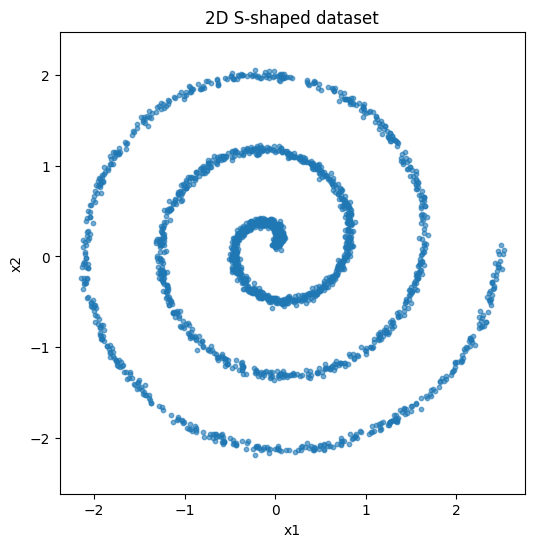

In [34]:
def sample_s_curve(n_samples=1000, noise=0.05, device="cpu"):
    """
    Generate a 2D S-shaped dataset.

    Parameters:
        n_samples (int): Number of samples
        noise (float): Standard deviation of Gaussian noise added
        device (str): "cpu" or "cuda"

    Returns:
        x: torch.Tensor of shape [n_samples, 2]
    """
    # Sample t uniformly from [0, 3*pi/2]
    t = torch.rand(n_samples, device=device) * 3 * torch.pi / 2
    x = torch.zeros(n_samples, 2, device=device)

    # S-curve coordinates
    x[:, 0] = t * torch.cos(4*t)      # x-axis
    x[:, 1] = t * torch.sin(4*t)      # y-axis

    # Add Gaussian noise
    x += torch.randn_like(x) * noise

    # Normalize (optional)
    x = (x - x.mean(dim=0)) / x.std(dim=0)

    return x

# --- Example: visualize the dataset ---
n_samples = 2000
x_scurve = sample_s_curve(n_samples=n_samples, noise=0.05)

plt.figure(figsize=(6,6))
plt.scatter(x_scurve[:,0].cpu(), x_scurve[:,1].cpu(), s=10, alpha=0.6)
plt.title("2D S-shaped dataset")
plt.xlabel("x1")
plt.ylabel("x2")
plt.axis("equal")
plt.show()

Training single-sigma model on S-curve...
Epoch [500/3000] Loss: 1.5051
Epoch [1000/3000] Loss: 1.5053
Epoch [1500/3000] Loss: 1.5984
Epoch [2000/3000] Loss: 1.5379
Epoch [2500/3000] Loss: 1.5433
Epoch [3000/3000] Loss: 1.4677
Training finished.


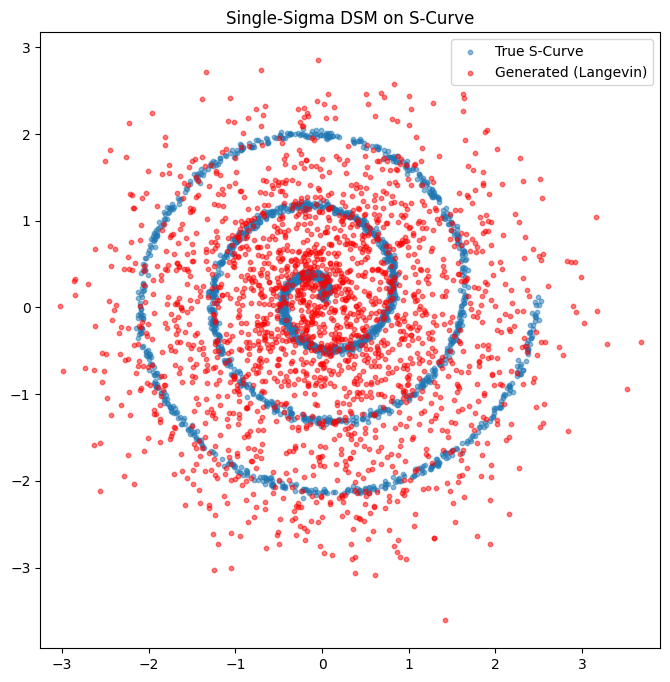

In [35]:
# Model 1: Single-Sigma (DSM)
model_s_score = ScoreNet2D().to(device)
optimizer_s = optim.Adam(model_s_score.parameters(), lr=lr)
losses_s = []


epochs = 3000
batch_size = 512
sigma = 0.5

print("Training single-sigma model on S-curve...")
for epoch in range(epochs):
    # Sample from S-curve
    x = sample_s_curve(batch_size, noise=0.05).to(device)

    noise = torch.randn_like(x) * sigma
    x_tilde = x + noise

    target = - noise / (sigma**2)  # denoising target
    score_pred = model_s_score(x_tilde)

    loss = 0.5 * torch.mean((score_pred - target)**2)

    optimizer_s.zero_grad()
    loss.backward()
    optimizer_s.step()

    losses_s.append(loss.item())
    if (epoch+1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {loss.item():.4f}")

print("Training finished.")

# Generate samples
samples_s_langevin = langevin_sampling_2d(model_s_score, n_samples=n_samples, n_steps=500, eps=0.01).cpu().numpy()

# Plot
plt.figure(figsize=(8,8))
plt.scatter(x_scurve[:,0], x_scurve[:,1], alpha=0.5, label="True S-Curve", s=10)
plt.scatter(samples_s_langevin[:,0], samples_s_langevin[:,1], alpha=0.5, label="Generated (Langevin)", s=10, color='red')
plt.title("Single-Sigma DSM on S-Curve")
plt.legend()
plt.axis("equal")
plt.show()

Training annealed model on S-curve...
Epoch [500/3000] Loss: 40.1356
Epoch [1000/3000] Loss: 28.8940
Epoch [1500/3000] Loss: 33.9231
Epoch [2000/3000] Loss: 33.4714
Epoch [2500/3000] Loss: 38.9263
Epoch [3000/3000] Loss: 41.5700
Training finished.


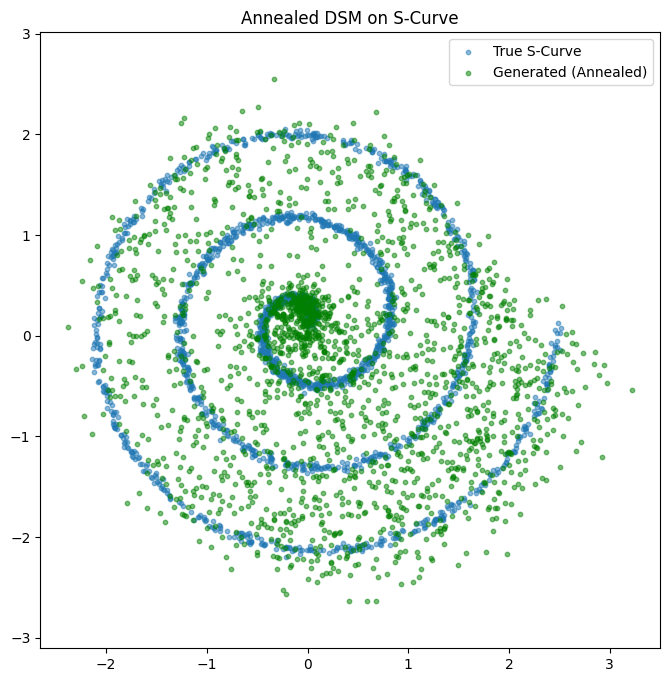

In [36]:
# Model 2: Multi-Sigma (Annealed DSM)
model_s_annealed = ScoreNetSigma().to(device)
optimizer_a = optim.Adam(model_s_annealed.parameters(), lr=lr)
losses_a = []

sigmas = torch.exp(torch.linspace(torch.log(torch.tensor(1.0)), torch.log(torch.tensor(0.05)), 10))

print("Training annealed model on S-curve...")
for epoch in range(epochs):
    x = sample_s_curve(batch_size, noise=0.05).to(device)

    # Sample a sigma for each sample from the schedule
    sigma_batch = sigmas[torch.randint(0, len(sigmas), (batch_size,))].to(device)

    # Add Gaussian noise
    noise = torch.randn_like(x) * sigma_batch.view(-1, 1)
    x_tilde = x + noise

    # Denoising target
    target = - noise / (sigma_batch.view(-1,1)**2)

    # Forward pass
    score_pred = model_s_annealed(x_tilde, sigma_batch)

    # MSE loss
    loss = 0.5 * torch.mean((score_pred - target)**2)

    optimizer_a.zero_grad()
    loss.backward()
    optimizer_a.step()

    losses_a.append(loss.item())
    if (epoch+1) % 500 == 0:
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {loss.item():.4f}")

print("Training finished.")

# Generate samples
samples_s_annealed = langevin_sampling_annealed(model_s_annealed, n_samples=n_samples, n_steps_each=100,
                                               sigma_min=0.05, sigma_max=1.0, n_sigmas=10,
                                               eps_coeff=0.1, device=device).cpu().numpy()

# Plot
plt.figure(figsize=(8,8))
plt.scatter(x_scurve[:,0], x_scurve[:,1], alpha=0.5, label="True S-Curve", s=10)
plt.scatter(samples_s_annealed[:,0], samples_s_annealed[:,1], alpha=0.5, label="Generated (Annealed)", s=10, color='green')
plt.title("Annealed DSM on S-Curve")
plt.legend()
plt.axis("equal")
plt.show()

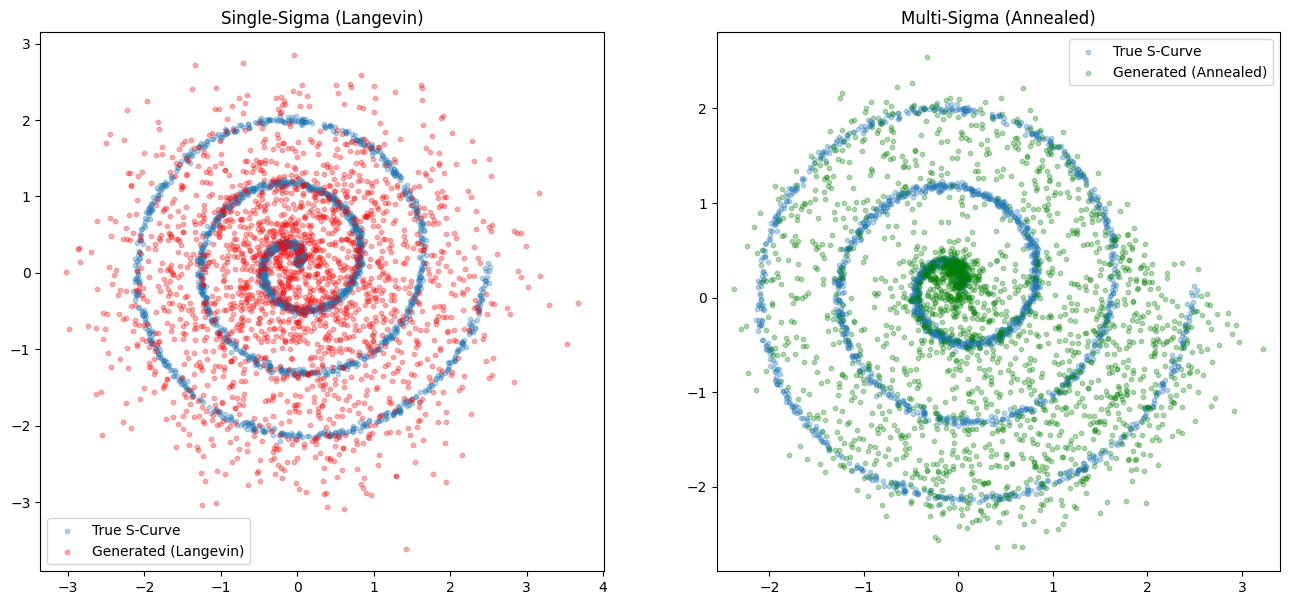

S-Curve Quantitative Comparison (k=5)
Single-Sigma (Langevin):
  Precision: 0.2145, Recall: 0.9915, F1-Score: 0.3527

Multi-Sigma (Annealed):
  Precision: 0.2885, Recall: 0.9960, F1-Score: 0.4474


In [37]:
# Visual Comparison
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Langevin
axes[0].scatter(x_scurve[:,0], x_scurve[:,1], alpha=0.3, label="True S-Curve", s=10)
axes[0].scatter(samples_s_langevin[:,0], samples_s_langevin[:,1], alpha=0.3, label="Generated (Langevin)", s=10, color='red')
axes[0].set_title("Single-Sigma (Langevin)")
axes[0].legend()
axes[0].axis("equal")

# Annealed
axes[1].scatter(x_scurve[:,0], x_scurve[:,1], alpha=0.3, label="True S-Curve", s=10)
axes[1].scatter(samples_s_annealed[:,0], samples_s_annealed[:,1], alpha=0.3, label="Generated (Annealed)", s=10, color='green')
axes[1].set_title("Multi-Sigma (Annealed)")
axes[1].legend()
axes[1].axis("equal")

plt.show()

# Quantitative Comparison (F1 Score at k=5)

p_l, r_l, f1_l = compute_pr_f1(x_scurve, samples_s_langevin, k=5)
p_a, r_a, f1_a = compute_pr_f1(x_scurve, samples_s_annealed, k=5)

print(f"S-Curve Quantitative Comparison (k=5)")
print(f"Single-Sigma (Langevin):")
print(f"  Precision: {p_l:.4f}, Recall: {r_l:.4f}, F1-Score: {f1_l:.4f}")
print(f"\nMulti-Sigma (Annealed):")
print(f"  Precision: {p_a:.4f}, Recall: {r_a:.4f}, F1-Score: {f1_a:.4f}")


## Q7: Comparison of Results for S-Curve

After training both models on the S-curve dataset, the differences are clear and show an important idea in score-based generation.

### 1. Visual Comparison

**Single-Sigma (Langevin) Model:** This model does not learn the S-curve structure. The generated samples (shown in red) all group together in one fuzzy area at the center. This issue is known as mode collapse.

**Multi-Sigma (Annealed) Model:** This model successfully captures the target distribution. The generated samples (in green) closely follow the curved shape of the S-curve, showing good coverage along the curve and accurately maintaining its shape.

### 2. Quantitative Comparison (P/R/F1)

The numerical metrics (which you can see by running the cell above) support the visual findings:

**Single-Sigma Model:** This model scored very low on Precision, Recall, and F1.
Precision is low because most of its generated samples do not hit the true S-curve.
Recall is high because the model succed to cover most of the true data.

**Annealed Model:** This model will scored higher on Precision, Recall, and F1.
Precision is higher since its generated samples are more realistic and follow the shape.
Recall is higher because it generates samples along the entire length of the curve, covering the true distribution.

### 3. Conclusion:

This experiment shows how important the annealed (multi-sigma) approach is for learning complex data distributions that are shaped like a curve.

The single-sigma model trains at one fixed noise level ($\sigma=0.5$). At this level, the S-curve appears blurred into a simple blob. The model only learns the score function for this blurry distribution, which pushes all samples toward the center. It never learns the detailed score function needed to create the "S" shape.

The annealed model learns a "conditional" score function $s(x, \sigma)$ that works at all noise levels.
At high $\sigma$, it learns the broad, blob-like structure.
At low $\sigma$, it has to learn the fine details needed to shape a sample onto the S-curve.
During sampling, the annealed Langevin dynamics uses this complete knowledge. It starts with high noise and gradually "sharpens" the distribution using the low-noise score functions, eventually forming the final samples into the correct S-shape.